# Regional Property Price Analysis: England 2017-2018

**Author:** Rashad Malik

## Project aim and outline

The UK **Ministry of Housing, Communities & Local Government** have requested an analysis of regional property price changes in England over a one-year period. This analysis includes testing the independence of price trends from regional classification using statistical methods.

This study provides insights into regional market dynamics and evaluates the effectiveness of statistical tests in capturing these relationships.

The notebook contains the following sections:
- **Introduction**
  - Importing required libraries, describing the dataset and loading the data
- **Analysis**
  - Part 1: Calculating and displaying price changes
  - Part 2: Statistical analysis
  - Part 3: Discussion
- **Summary and conclusion**
- **References**

## Introduction

### Importing libraries

The following libraries are required for our analysis:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, percentileofscore
%matplotlib inline

### The dataset

#### Dataset description and variables

The file `average-flat-prices.csv` has information about the average price of flats (also called apartments) in England over a 36 month period. The dataset contains the following fields:

| Field Name  | Description                                                                                   |
|-------------|-----------------------------------------------------------------------------------------------|
| Area        | The name of a local government area                                                           |
| Code        | The code of the area                                                                          |
| Price       | Average sale price of a flat (an apartment) property in this area in the month                |
| Month        | A date, which is the first of the month, between September 1st 2016 and August 1st 2019. 36 months in total |
| RegionName  | The name of the region of which this area is part                                             |
| RegionCode  | The code of the region                                                                        |

Additionally, the first three characters of the `Code` column specifies the type of local government area. The distinction of area type is not important in our analysis, this is just additional context for the `Code` variable.

| Code Prefix | Type of Area                 |
|-------------|------------------------------|
| E10         | County                       |
| E09         | London Borough              |
| E08         | Metropolitan Boroughs       |
| E06         | English unitary authority   |

#### Data loading

In [2]:
# Loading the dataset
prices = pd.read_csv("data/average_flat_prices.csv")

# Printing dataframe information
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5436 entries, 0 to 5435
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        5436 non-null   object 
 1   Code        5436 non-null   object 
 2   Price       5436 non-null   float64
 3   Month       5436 non-null   object 
 4   RegionName  5436 non-null   object 
 5   RegionCode  5436 non-null   object 
dtypes: float64(1), object(5)
memory usage: 254.9+ KB


The data has been successfully loaded, and our dataframe `prices` contains **5'436 rows**, and **6 columns**.

We can also see there are no missing (null) cells. However, the month column is marked as an "object" data-type, so firstly we will convert it into a **datetime** attribute, which will allow us to manipulate the data more easily.

In [3]:
# Converting month column into datetime type
prices["Month"] = pd.to_datetime(prices["Month"])
print("'Month' Dtype:", prices["Month"].dtype)

'Month' Dtype: datetime64[ns]


The column has successfully been changed to datetime, so we are now ready to proceed with our analysis.

## Analysis

### Part 1: Calculating and displaying price changes

#### 1.1 Calculating price changes

I will compare the change in average flat prices in each area between **July 2017** and **July 2018**.

I'll begin by creating a new dataframe with the average prices for each area in those two dates.

In [4]:
# Filtering the data for July 2017 and July 2018
july_2017 = prices[prices["Month"] == "2017-07-01"]
july_2018 = prices[prices["Month"] == "2018-07-01"]

# Merging the data into a new dataframe
price_changes = pd.merge(july_2017[["Area", "RegionName", "Price"]],
                         july_2018[["Area", "RegionName", "Price"]],
                         on=["Area", "RegionName"],
                         suffixes=("_2017", "_2018"))

# Calculating the price difference and percentage change
price_changes["Price Difference"] = price_changes["Price_2018"] - price_changes["Price_2017"]
price_changes["Percentage Change"] = ((price_changes["Price_2018"] - price_changes["Price_2017"]) / price_changes["Price_2017"]) * 100

#### 1.2 Visualising price changes

Next I will create plots to help visualise the change in area prices in each region. I'll use two visualisations:
- **Overall dot-plot**: The dot plot will allow viewing the overarching distribution of price changes across all regions.
- **Regional bar charts**: The 9 subplots will allow viewing price changes at a more granular level for each individual region.

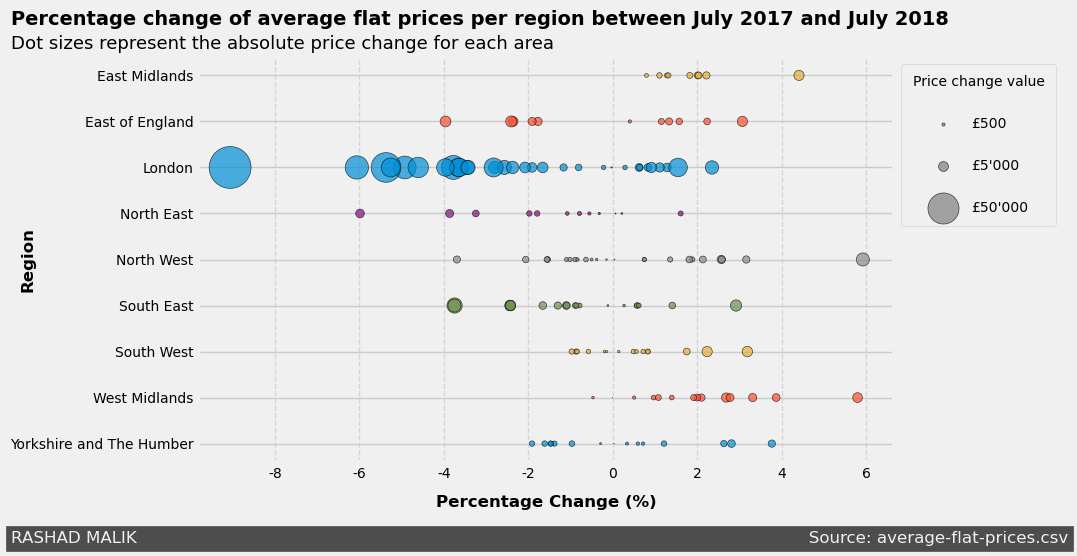

In [5]:
# Sorting the data by RegionName alphabetically
price_changes = price_changes.sort_values("RegionName", ascending=False)
region_names = price_changes["RegionName"].unique()

# Setting the plot style
plt.style.use("fivethirtyeight")

# Creating the dot plot
fig, ax = plt.subplots(figsize=(8, 5))

for region in price_changes["RegionName"].unique():
    region_data = price_changes[price_changes["RegionName"] == region]
    ax.scatter(region_data["Percentage Change"], [region] * len(region_data),
               s=abs(region_data["Price Difference"]) / 100, alpha=0.7, edgecolor="k")

ax.set_yticks(range(len(region_names)))
ax.set_yticklabels(region_names, fontsize=10)
ax.set_xlabel("Percentage Change (%)", fontsize=12, fontweight="bold", labelpad=10)
ax.set_ylabel("Region", fontsize=12, fontweight="bold", labelpad=-18)
ax.grid(axis="x", linestyle="--", alpha=0.7)

x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks)
ax.set_xticklabels([f"{tick:.0f}" for tick in x_ticks], fontsize=10)

# Adding a legend that explains dot sizes
sizes = [500, 5000, 50000]
labels = [f"{size:,}".replace(",", "'") for size in sizes]
for size, label in zip(sizes, labels):
    ax.scatter([], [], s=size / 100, alpha=0.7, edgecolor="k", color="grey", label=f"£{label}")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-len(sizes):], labels[-len(sizes):], title="Price change value", bbox_to_anchor=(1.0, 1),
          loc="upper left", frameon=True, labelspacing=2, handletextpad=1, borderpad=0.8, fontsize=10, title_fontsize=10)

# Titles and signature
plt.text(-0.27, 1.08,
         "Percentage change of average flat prices per region between July 2017 and July 2018", 
         size=14, weight="bold", color="black", 
         transform=plt.gca().transAxes)
plt.text(-0.27, 1.02,
         "Dot sizes represent the absolute price change for each area", 
         size=13, color="black", 
         transform=plt.gca().transAxes)
plt.text(-0.27, -0.2,
         "RASHAD MALIK" + " " * 128 + "Source: average-flat-prices.csv", 
         color="#f0f0f0", 
         backgroundcolor="#4d4d4d", 
         fontsize=12, 
         transform=plt.gca().transAxes)

plt.show()

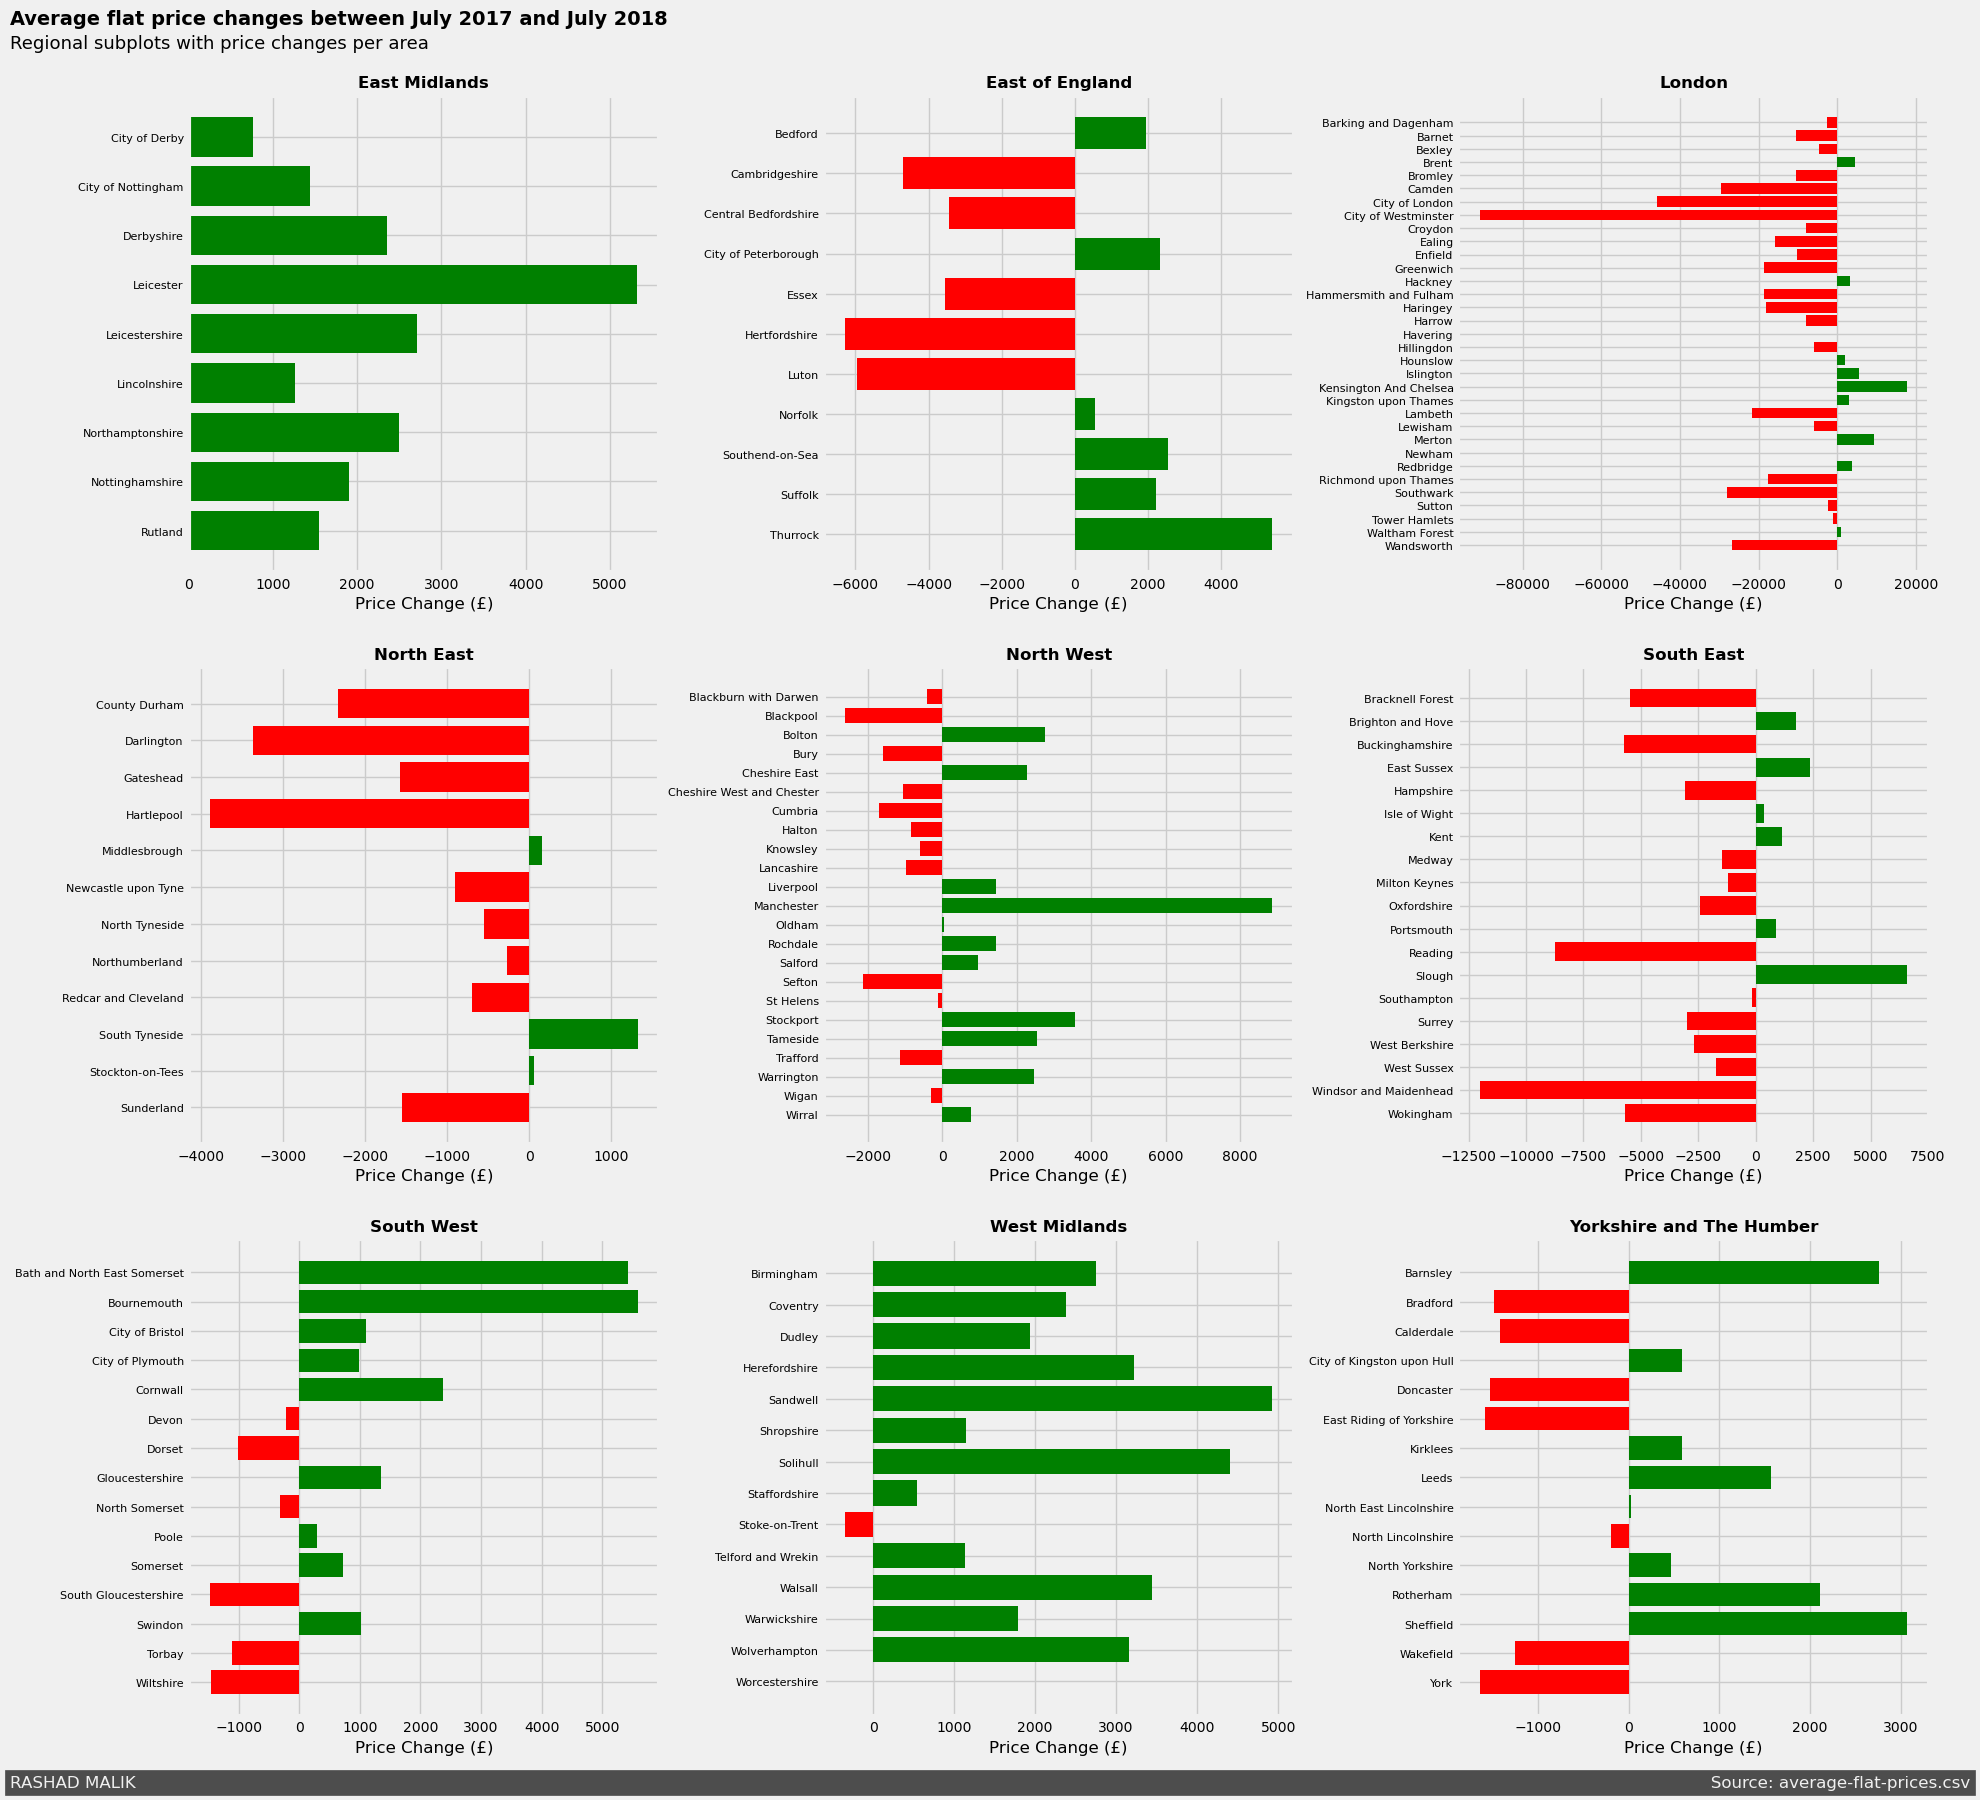

In [6]:
# Changing the order of region names so that it remains alphabetical for the next visualisation
price_changes = price_changes.sort_values("RegionName", ascending=True)
regions = price_changes["RegionName"].unique()

fig, axes = plt.subplots(3, 3, figsize=(20, 20))  # 5 rows, 2 columns
axes = axes.flatten()
for i, region in enumerate(regions):
    regional_data = price_changes[price_changes["RegionName"] == region]
    regional_data = regional_data.sort_values(by="Area", ascending=False)
    colours = regional_data["Price Difference"].apply(lambda x: "green" if x > 0 else "red")
    ax = axes[i]
    ax.barh(regional_data["Area"], regional_data["Price Difference"], color=colours)
    ax.set_title(region, fontsize=12, weight="bold")
    ax.set_xlabel("Price Change (£)", fontsize=12)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=8)

plt.subplots_adjust(wspace=0.35, hspace=0.2)

# Titles and signature
plt.text(-3.08, 3.55,
         "Average flat price changes between July 2017 and July 2018", 
         size=14, weight="bold", color="black", 
         transform=plt.gca().transAxes)
plt.text(-3.08, 3.5,
         "Regional subplots with price changes per area", 
         size=13, color="black", 
         transform=plt.gca().transAxes)
plt.text(-3.08, -0.15,
         "RASHAD MALIK" + " " * 300 + "Source: average-flat-prices.csv", 
         color="#f0f0f0", 
         backgroundcolor="#4d4d4d", 
         fontsize=12, 
         transform=plt.gca().transAxes)

plt.show()

#### 1.3 Commenting on results

I can now make some observations from the above visualisations. The **dot plot** reveals that **London** exhibits the most significant variation of data points, reflecting the widest range of **percentage changes** in flat prices, with some areas experiencing slight **positive changes**, while others face significant **declines** (London is the only region with percentage declines beyond -6%). Regions like the **North East** and the **South East** mostly show **negative changes**, suggesting potential economic struggles in these areas. Conversely, regions such as the **East Midlands** and parts of the **West Midlands** show strong **positive changes** in specific areas, potentially indicating development in these areas.

Additionally, across all regions, there's a pattern where the further from 0%, the larger the dots tend to get. This indicates that in general, **areas with higher priced flats tend to have larger (positive or negative) price changes**. 

The **bar chart subplots** further illustrate these trends, showing that **London** stands out with the largest **absolute price changes** both positive and negative, reflecting the **volatility** of its housing market. The City of Westminster is the area with the largest price change in the dataset, decreasing in price by over £80'000.

Overall, **regional disparities in price changes are evident**, with specific regions struggling and other regions showing more positive trends. These patterns underscore the influence of **economic, social, and infrastructural factors** on flat price changes across England.

### Part 2: Statistical analysis

#### 2.1 Cross-tabulation

I will now move on to statistical tests of the regional price changes between July 2017 and July 2018.

First, I'll cross-tabulate the number of areas in which the price has increased or decreased by region.

In [7]:
# Creating a new column
price_changes["Change Direction"] = price_changes.apply(
    lambda row: "Increased" if row["Price_2018"] > row["Price_2017"] 
    else "Decreased" if row["Price_2018"] < row["Price_2017"] 
    else "No Change",
    axis=1
)

# Using groupby to create a crosstab result
crosstab_result = (
    price_changes.groupby("RegionName")["Change Direction"]
    .value_counts()
    .unstack(fill_value=0)
)

crosstab_result

Change Direction,Decreased,Increased
RegionName,,
East Midlands,0,9
East of England,5,6
London,23,10
North East,9,3
North West,12,11
South East,13,6
South West,6,9
West Midlands,2,12
Yorkshire and The Humber,7,8


#### 2.2 Chi-square test and permutation test

I will use two methods to test the independence of region vs. prices changes:
- **Chi-square test**
- **Permutation test**

The chi-square test is a statistical test used to determine whether there is a significant association between two categorical variables by comparing **observed and expected frequencies** in a contingency table. Additionally, I'll use the **G statistic** (also known as the likelihood ratio chi-square statistic), which is an alternative to the Pearson chi-square statistic:

In [8]:
# Calculating the G-test statistic and the p-value
test_stat, p_value, dof, expected = chi2_contingency(crosstab_result, correction=False,
                                                     lambda_ = "log-likelihood")
print('The G test statistic is %4.2f' % test_stat)
print('The p-value is %4.3f %%' % (100 * p_value))

The G test statistic is 32.19
The p-value is 0.009 %


I have successfully calculated the G statistic and the chi-square p-value. I will now continue with the permutation test, and discuss and compare the results of both tests at the end of this section. A permutation test is a statistical test used to assess the significance of an observed effect by comparing it to a distribution of effects generated by **randomly shuffling the data**. Additionally, I'll create a **histogram of generated G-statistics** from the permutation test.

> **NOTE**: As this test involves randomness, I'll set a seed to ensure reproducible testing with code from this notebook.

In [9]:
# Setting a random seed
seed = 42
np.random.seed(seed)

# Permutation test
permuted_g_stats = []
for _ in range(20000):
    shuffled = price_changes["Change Direction"].sample(frac=1, replace=False, random_state=np.random.randint(0, 1e6)).reset_index(drop=True)
    permuted_table = pd.crosstab(price_changes["RegionName"], shuffled)
    permuted_g, _, _, _ = chi2_contingency(permuted_table, lambda_="log-likelihood")
    permuted_g_stats.append(permuted_g)

# Calculating the p-value
p_value = np.mean(np.array(permuted_g_stats) >= test_stat)

# Unique tables count
unique_tables = len(np.unique(permuted_g_stats))

# Calculating p-value percent
p_value_percent = 100 * (1 - percentileofscore(permuted_g_stats, test_stat, kind="strict") / 100)

print(f"Random seed used: {seed}")
print(f"Generated {unique_tables} unique tables out of 20'000 total permutations")
print(f"The p-value for the test is {p_value_percent:.3f} %")

Random seed used: 42
Generated 19087 unique tables out of 20'000 total permutations
The p-value for the test is 0.020 %


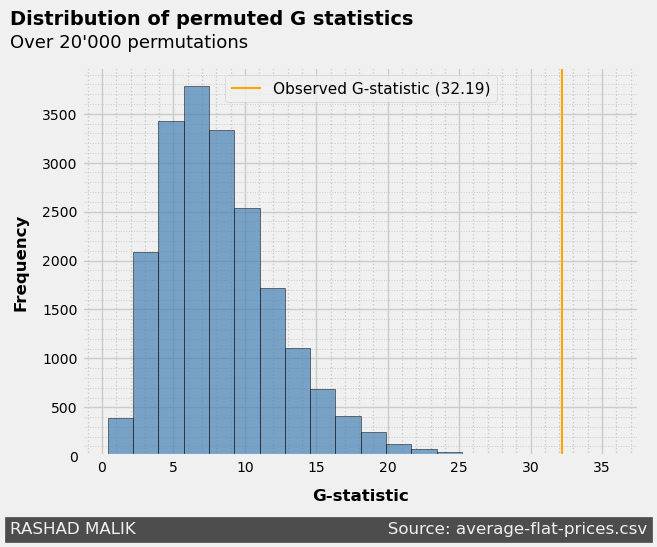

In [10]:
# Creating the G statistic histogram 
plt.hist(permuted_g_stats, bins=20, log=False, color="steelblue", edgecolor="black", alpha=0.7)
plt.axvline(test_stat, color="orange", linestyle="-", linewidth=1.5, label=f"Observed G-statistic ({test_stat:.2f})")
plt.xlabel("G-statistic", fontsize = 12, fontweight = "bold", labelpad = 10)
plt.ylabel("Frequency", fontsize = 12, fontweight = "bold", labelpad = 10)
plt.tick_params(axis="x", labelsize=10)
plt.tick_params(axis="y", labelsize=10)
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
plt.grid(which="minor", axis="x", linestyle=":", linewidth=1)
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(100))
plt.grid(which="minor", axis="y", linestyle=":", linewidth=0.7)

# Titles and signature
plt.text(-0.13, 1.11,
         "Distribution of permuted G statistics", 
         size=14, weight="bold", color="black", 
         transform=plt.gca().transAxes)
plt.text(-0.13, 1.05,
         "Over 20'000 permutations", 
         size=13, color="black", 
         transform=plt.gca().transAxes)
plt.text(-0.13, -0.2,
         "RASHAD MALIK" + " " * 48 + "Source: average-flat-prices.csv", 
         color="#f0f0f0", 
         backgroundcolor="#4d4d4d", 
         fontsize=12, 
         transform=plt.gca().transAxes)

plt.legend(fontsize=11)
plt.show()

### Part 3: Discussion

I have successfully conducted both a **chi-square test**, and a **permutation test** on the data. Both of these tests are designed around two main hypotheses:
- **Null Hypothesis ($H_0$)**: There is **no association** between `Change Direction` (whether average flat prices increased or decreased) and `RegionName` (regions in England).
- **Alternative Hypothesis ($H_1$)**: There is a **statistically significant association** between `Change Direction` and `RegionName`, and is not likely due to random chance.

The table below shows the key statistics acquired from running the above tests.

| Test Name         | Observed G Statistic | p-value   |
|-------------------|----------------------|-----------|
| Chi-Square Test   | 32.19                | 0.009%    |
| Permutation Test  | 32.19                | 0.020%    |

The significance level ($\alpha$) is typically set at 0.05 (5%). If the p-value is less than that value, we can **reject the null hypothesis** and conclude that there is a statistically significant association between the Change Direction and Region.

Looking at the p-values for both tests, they are essentially 0%, meaning we can reject the null hypothesis and conclude that **the association between the two variables is very unlikely to be just due to chance**.

Furthermore, the permutation test helps demonstrate this fact further. In the multiple permutations, G statistics were generated for different combinations of the two variables. Over the 20'000 permutations, **only 0.02% of the G-statistics were equal or greater than the observed G statistic** of 32.2, meaning this specific combination of Region and Change Direction is an extremely rare occurrence, highlighting the improbability of it being just due to chance.

The histogram also clearly highlights this case, as **the observed G statistic exists far to the right** from the commonly occurring permuted G statistics. Since the permutation test randomly creates a new table each cycle, out of the 20'000 total permutations, 19087 unique tables were generated (some were repeated due to chance). The higher the total permutations in the test, the more accurate the result, however this takes up more computing power. In this case, **running the permutation test multiple times still yielded similar results**, thus we can be confident in rejecting the null hypothesis.

## Summary and conclusion

This analysis explored how property prices changed across regions in England between July 2017 and July 2018. Using visualisations and statistical tests, I examined whether the direction of price changes (whether prices increased or decreased) was connected to the region.

The results of the statistical tests were clear. Both the chi-square test and the permutation test gave highly significant results, with p-values of **0.009%** and **0.020%**, respectively. These figures are far below the typical threshold of 5%, which means **we can confidently reject the idea that the direction of price changes is unrelated to the region**. The observed G-statistic of 32.19 was much higher than almost all the values generated during the permutation test, showing that the relationship between region and price changes is very unlikely to be due to chance.

The visualisations backed up these findings. London stood out for its price volatility, with areas experiencing both significant increases and decreases. Meanwhile, regions like the North East and South East showed predominantly negative trends, suggesting potential economic struggles in these areas. On the other hand, places like the East Midlands displayed strong positive price changes, possibly indicating development or growth in those regions.

In summary, this analysis demonstrates a clear link between regional classifications and the direction of property price changes. This information could help inform policy decisions and better understand the housing market in England.

## References

1. **Ministry of Housing, Communities & Local Government**, *GOV.UK*, Accessed on: November 2024, [https://www.gov.uk/](https://www.gov.uk/government/organisations/ministry-of-housing-communities-local-government)
2. **SciPy Documentation - Chi-Square Test**, *scipy.stats.chi2_contingency*, [https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html)